In [1]:
# ======================================================
# K-Nearest-Neighbor Evaluation
#      
# Suppose we are given:
#      * a number of events "N"
#      * a list of event indices "event_i"
#      * a list of event coordinates "event_latlng"
#      * some number of events "K" < N
#      * the coordinates "Q_latlng" of some arbitrary 
#            point Q on earth's surface
#
# The code in this cell returns [the list of indices for
# the K events whose proximity is nearest to point Q]
# for each of the N events.
#
# Michael Collins, Flatiron School
# 2020-10-28_0524_MDT
#
# ======================================================

import math
from IPython.display import display
from openlocationcode import openlocationcode as olc
from geographiclib.geodesic import Geodesic
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as scs
import statsmodels.api as sm
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy.spatial import distance
# from fractions import Fraction
# import plotly.express as px
# import requests

OLC_CODE_PLANET = "00000000+"
OLC_EARTH_CIRCUMFERENCE = np.round(2 * np.pi * Geodesic.WGS84.a, 3)
OLC_LATITUDE_SPAN = 180.0
OLC_LATITUDE_SOUTH_POLE = -90.0
OLC_LATITUDE_EQUATOR = 0.0
OLC_LATITUDE_NORTH_POLE = 90.0
OLC_LONGITUDE_SPAN = 360.0
OLC_LONGITUDE_DATELINE_WEST = -180.0
OLC_LONGITUDE_GREENWICH = 0.0
OLC_LONGITUDE_DATELINE_EAST = 180.0

OLC_PYLON_MIDPOINT = "midpoint"
OLC_PYLON_O = OLC_PYLON_MIDPOINT
OLC_PYLON_N = "pylon_N"
OLC_PYLON_NE = "pylon_NE"
OLC_PYLON_E = "pylon_E"
OLC_PYLON_SE = "pylon_SE"
OLC_PYLON_S = "pylon_S"
OLC_PYLON_SW = "pylon_SW"
OLC_PYLON_W = "pylon_W"
OLC_PYLON_NW = "pylon_NW"
OLC_BORDER_PYLONs = [OLC_PYLON_N, OLC_PYLON_NE, OLC_PYLON_E, OLC_PYLON_SE,
                     OLC_PYLON_S, OLC_PYLON_SW, OLC_PYLON_W, OLC_PYLON_NW]
OLC_PYLONs = [OLC_PYLON_O] + OLC_BORDER_PYLONs

OLC_OFFSET_N = "offset_N"
OLC_OFFSET_NE = "offset_NE"
OLC_OFFSET_E = "offset_E"
OLC_OFFSET_SE = "offset_SE"
OLC_OFFSET_S = "offset_S"
OLC_OFFSET_SW = "offset_SW"
OLC_OFFSET_W = "offset_W"
OLC_OFFSET_NW = "offset_NW"
OLC_CARDINAL_OFFSETs = [OLC_OFFSET_N, OLC_OFFSET_E, OLC_OFFSET_S, OLC_OFFSET_W]
OLC_DIAGONAL_OFFSETs = [OLC_OFFSET_NE, OLC_OFFSET_SE, OLC_OFFSET_SW, OLC_OFFSET_NW]
OLC_OFFSETs = [OLC_OFFSET_N, OLC_OFFSET_NE, OLC_OFFSET_E, OLC_OFFSET_SE,
               OLC_OFFSET_S, OLC_OFFSET_SW, OLC_OFFSET_W, OLC_OFFSET_NW]

OLC_TAU_PLANET = 0    # (180)-degree by (360)-degree resolution
OLC_TAU_DOMAIN = 1    # (20)-degree by (20)-degree resolution
OLC_TAU_SHIRE = 2     # (1)-degree by (1)-degree resolution
OLC_TAU_TOWNSHIP = 3  # (1/20)-degree by (1/20)-degree resolution
OLC_TAU_HOLLER = 4    # (1/400)-degree by (1/400)-degree resolution
OLC_TAU_ROOFTOP = 5   # (1/8000)-degree by (1/8000)-degree resolution
OLC_TAU_PARLOR = 6    # (1/40000)-degree by (1/32000)-degree resolution
OLC_TAU_DESK = 7      # subdivides the above into a 5-tall by 4-wide grid
OLC_TAU_ENVELOPE = 8  # subdivides the above into a 5-tall by 4-wide grid
OLC_TAU_ERASER = 9    # subdivides the above into a 5-tall by 4-wide grid
OLC_TAU_STAPLE = 10   # subdivides the above into a 5-tall by 4-wide grid
OLC_TAUs = [OLC_TAU_PLANET, OLC_TAU_DOMAIN, OLC_TAU_SHIRE,
            OLC_TAU_TOWNSHIP, OLC_TAU_HOLLER, OLC_TAU_ROOFTOP,
            OLC_TAU_PARLOR, OLC_TAU_DESK, OLC_TAU_ENVELOPE,
            OLC_TAU_ERASER, OLC_TAU_STAPLE]

OLC_TAU_BEDROCK = OLC_TAU_ROOFTOP
OLC_GRID_NORTH_MAX = np.prod([9, 20, 20, 20, 20][0:OLC_TAU_BEDROCK])
OLC_GRID_EAST_MAX = np.prod([18, 20, 20, 20, 20][0:OLC_TAU_BEDROCK])


OLC_TIER_PLANET = "planet"      # (180)-degree by (360)-degree resolution
OLC_TIER_DOMAIN = "domain"      # (20)-degree by (20)-degree resolution
OLC_TIER_SHIRE = "shire"        # (1)-degree by (1)-degree resolution
OLC_TIER_TOWNSHIP = "township"  # (1/20)-degree by (1/20)-degree resolution
OLC_TIER_HOLLER = "holler"      # (1/400)-degree by (1/400)-degree resolution
OLC_TIER_ROOFTOP = "rooftop"    # (1/8000)-degree by (1/8000)-degree resolution
OLC_TIER_PARLOR = "parlor"      # (1/40000)-degree by (1/32000)-degree resolution
OLC_TIER_DESK = "desk"          # subdivides the above into a 5-tall by 4-wide grid
OLC_TIER_ENVELOPE = "envelope"  # subdivides the above into a 5-tall by 4-wide grid
OLC_TIER_ERASER = "eraser"      # subdivides the above into a 5-tall by 4-wide grid
OLC_TIER_STAPLE = "staple"      # subdivides the above into a 5-tall by 4-wide grid
OLC_TIERs = [OLC_TIER_PLANET, OLC_TIER_DOMAIN, OLC_TIER_SHIRE,
             OLC_TIER_TOWNSHIP, OLC_TIER_HOLLER, OLC_TIER_ROOFTOP,
             OLC_TIER_PARLOR, OLC_TIER_DESK, OLC_TIER_ENVELOPE,
             OLC_TIER_ERASER, OLC_TIER_STAPLE]

OLC_CODELEN_PLANET = 0      # (180)-degree by (360)-degree resolution
OLC_CODELEN_DOMAIN = 2      # (20)-degree by (20)-degree resolution
OLC_CODELEN_SHIRE = 4        # (1)-degree by (1)-degree resolution
OLC_CODELEN_TOWNSHIP = 6  # (1/20)-degree by (1/20)-degree resolution
OLC_CODELEN_HOLLER = 8      # (1/400)-degree by (1/400)-degree resolution
OLC_CODELEN_ROOFTOP = 10    # (1/8000)-degree by (1/8000)-degree resolution
OLC_CODELEN_PARLOR = 11      # (1/40000)-degree by (1/32000)-degree resolution
OLC_CODELEN_DESK = 12          # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELEN_ENVELOPE = 13  # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELEN_ERASER = 14      # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELEN_STAPLE = 15      # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELENs = [OLC_CODELEN_PLANET, OLC_CODELEN_DOMAIN, OLC_CODELEN_SHIRE,
                OLC_CODELEN_TOWNSHIP, OLC_CODELEN_HOLLER, OLC_CODELEN_ROOFTOP,
                OLC_CODELEN_PARLOR, OLC_CODELEN_DESK, OLC_CODELEN_ENVELOPE,
                OLC_CODELEN_ERASER, OLC_CODELEN_STAPLE]

OLC_tau_to_tier = dict(zip(OLC_TAUs, OLC_TIERs))
OLC_tier_to_tau = dict(zip(OLC_TIERs, OLC_TAUs))
OLC_TIER_BEDROCK = OLC_tau_to_tier[OLC_TAU_BEDROCK]

OLC_tau_to_codeLen = dict(zip(OLC_TAUs, OLC_CODELENs))

OLC_codeLen_to_tau = dict(zip(OLC_CODELENs, OLC_TAUs))

OLC_tier_to_codeLen = dict(zip(OLC_TIERs, OLC_CODELENs))

OLC_codeLen_to_tier = dict(zip(OLC_CODELENs, OLC_TIERs))

def sci_round(x, n):
    s = np.format_float_scientific(x, precision=n, trim='-')
    return float(s)

def olc_encode_tau(latlng, tau):
    if not tau in OLC_TAUs:
        return None
        
    if tau == OLC_TAU_PLANET:
        code = OLC_CODE_PLANET
    else:
        code = olc.encode(*latlng, OLC_tau_to_codeLen[tau])
    return code

def olc_add_zone_to_archive(this_zone):
    raw_dict = {}
    raw_dict[this_zone.code] = this_zone
    for child_zone in this_zone.children.values():
        child_dict = olc_add_zone_to_archive(child_zone)    
        raw_dict.update(child_dict)
    return dict(sorted(raw_dict.items()))

def olc_latitude_to_iNorth_fracN(latitude=None):
    if not isinstance(latitude, float):
        print(f"the latitude must be specified.")
        return None
    if not(OLC_LATITUDE_SOUTH_POLE <= latitude <= OLC_LATITUDE_NORTH_POLE):
        print(f"the latitude {latitude} is not valid.")
        return None
    if latitude == OLC_LATITUDE_SOUTH_POLE:
        return (0, 0.0)
    if latitude == OLC_LATITUDE_NORTH_POLE:
        return (OLC_GRID_NORTH_MAX - 1, 1.0)
    uNorth = sci_round((latitude - OLC_LATITUDE_SOUTH_POLE)*OLC_GRID_NORTH_MAX/OLC_LATITUDE_SPAN, 10)
    fN, iN = np.modf(uNorth)
    iNorth = int(iN)
    fracN = float(fN)
    return (iNorth, fracN)

def olc_longitude_to_iEast_fracE(longitude=None):
    if not isinstance(longitude, float):
        print(f"the longitude must be specified.")
        return None
    if not(OLC_LONGITUDE_DATELINE_WEST <= longitude <= OLC_LONGITUDE_DATELINE_EAST):
        print(f"the longitude {longitude} is not valid.")
        return None
    if longitude == OLC_LONGITUDE_DATELINE_WEST:
        return (0, 0.0)
    if longitude == OLC_LONGITUDE_DATELINE_EAST:
        return (OLC_GRID_EAST_MAX - 1, 1.0)
    uEast = sci_round((longitude - OLC_LONGITUDE_DATELINE_WEST)*OLC_GRID_EAST_MAX/OLC_LONGITUDE_SPAN, 10)
    fE, iE = np.modf(uEast)
    iEast = int(iE)
    fracE = float(fE)
    return (iEast, fracE)

class OLC_Offset:
    def __init__(self, lat1=None, lng1=None, lat2=None, lng2=None, mR_est=None, mN_est=None, mE_est=None):
        gripes = []
        
        has_est = True
        if mR_est is None:
            has_est = False
        if mN_est is None:
            has_est = False
        if mE_est is None:
            has_est = False
        if not has_est:
            mR_est, mN_est, mE_est = None, None, None
        
        if len(gripes) == 0:
            if has_est:
                if not isinstance(mR_est, float):
                    gripes.append(f"mR_est={mR_est} must be a floating-point number.")
                if not isinstance(mN_est, float):
                    gripes.append(f"mN_est={mN_est} must be a floating-point number.")
                if not isinstance(mE_est, float):
                    gripes.append(f"mE_est={mE_est} must be a floating-point number.")

        if len(gripes) == 0:
            if not isinstance(lat1, float):
                gripes.append(f"lat1={lat1} must be a floating point number.")
            elif not(OLC_LATITUDE_SOUTH_POLE <= lat1 <= OLC_LATITUDE_NORTH_POLE):
                gripes.append(f"lat1={lat1} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(lat2, float):
                gripes.append(f"lat2={lat2} must be a floating point number.")
            elif not(OLC_LATITUDE_SOUTH_POLE <= lat2 <= OLC_LATITUDE_NORTH_POLE):
                gripes.append(f"lat2={lat2} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(lng1, float):
                gripes.append(f"lng1={lng1} must be a floating point number.")
            elif not(OLC_LONGITUDE_DATELINE_WEST <= lng1 <= OLC_LONGITUDE_DATELINE_EAST):
                gripes.append(f"lng1={lng1} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(lng2, float):
                gripes.append(f"lng2={lng2} must be a floating point number.")
            elif not(OLC_LONGITUDE_DATELINE_WEST <= lng2 <= OLC_LONGITUDE_DATELINE_EAST):
                gripes.append(f"lng2={lng2} is not valid.")
        
        if len(gripes) == 0:
            try:
                gdict = Geodesic.WGS84.Inverse(lat1, lng1, lat2, lng2) # use the WGS84 ellipsoid
                
                # range in meters from latlng1 to latlng2 
                #      (rounded to nearest millimeter)
                range_meters_raw = gdict['s12']
                
                # components of forward azimuth at latlng1
                azi1_rad = np.radians(gdict['azi1'])          
                azi12_n = sci_round(np.cos(azi1_rad), 10)
                azi12_e = sci_round(np.sin(azi1_rad), 10)
            except:
                gripes.append(f"failure during Geodesic.WGS84.Inverse({lat1}, {lng1}, {lat2}, {lng2}).")
               
        if len(gripes) == 0:
            mR = np.round(range_meters_raw, 3)
            mN = np.round(range_meters_raw * azi12_n, 3)  # this is admittedly an estimate
            mE = np.round(range_meters_raw * azi12_e, 3)  # this is admittedly an estimate
            if has_est:
                delta_mR = np.round(mR_est - mR, 3)
                delta_mN = np.round(mN_est - mN, 3)
                delta_mE = np.round(mE_est - mE, 3)
            else:
                delta_mR = None
                delta_mN = None
                delta_mE = None

            self.valid = True
            self.latlng1 = (lat1, lng1)
            self.latlng2 = (lat2, lng2)
            self.mR = mR
            self.delta_mR = delta_mR
            self.mN = mN
            self.delta_mN = delta_mN
            self.mE = mE
            self.delta_mE = delta_mE   
            self.azi12_n = azi12_n
            self.azi12_e = azi12_e
        else:
            self.valid = False
            self.latlng1 = (lat1, lng1)
            self.latlng2 = (lat2, lng2)
            self.gripes = gripes

    def __str__(self):
        return f"|OLC_Offset({repr(self.latlng1)},{repr(self.latlng2)})|"

    def __repr__(self):
        s = []
        for k in self.__dict__:
            if k in ['mR', 'delta_mR', 'mN', 'delta_mN', 'mE', 'delta_mE']:
                s.append(f".{k}={repr(self.__dict__[k])}")
        return '|' + ', '.join(s) + '|'

class OLC_Point:
    def __init__(self, latitude=None, longitude=None):
        gripes = []
        
        if len(gripes) == 0:
            if not isinstance(latitude, float):
                gripes.append(f"the latitude must be specified.")
            elif not(OLC_LATITUDE_SOUTH_POLE <= latitude <= OLC_LATITUDE_NORTH_POLE):
                gripes.append(f"the latitude {latitude} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(longitude, float):
                gripes.append(f"the longitude must be specified.")
            elif not(OLC_LONGITUDE_DATELINE_WEST <= longitude <= OLC_LONGITUDE_DATELINE_EAST):
                gripes.append(f"the longitude {longitude} is not valid.")

        if len(gripes) == 0:
            iN_fN = olc_latitude_to_iNorth_fracN(latitude)
            if iN_fN is None:
                gripes.append(f"failure during olc_latitude_to_iNorth_fracN({latitude}).")
            else:
                iNorth, fracN = iN_fN
                
        if len(gripes) == 0:
            iE_fE = olc_longitude_to_iEast_fracE(longitude)
            if iE_fE is None:
                gripes.append(f"failure during olc_longitude_to_iEast_fracE({longitude}).")
            else:
                iEast, fracE = iE_fE
                
        if len(gripes) == 0:
            code_bedrock = olc_encode_tau((latitude, longitude), OLC_TAU_BEDROCK)
            if code_bedrock is None:
                gripes.append(f"failure during olc_encode_tau(({latitude}, {longitude}), {OLC_TAU_BEDROCK}).")
        
        if len(gripes) == 0:
            self.valid = True
            self.lat = latitude
            self.lng = longitude
            self.latlng = (latitude, longitude)
            self.uNorth = iNorth + fracN
            self.iNorth = iNorth
            self.fracN = fracN
            self.uEast = iEast + fracE
            self.iEast = iEast
            self.fracE = fracE
            self.code_bedrock = code_bedrock
            self.has_codes = False
        else:
            self.valid = False
            self.latlng = (latitude, longitude)
            self.has_codes = False
            self.gripes = gripes
    
    def code(self, tau=None, tier=None):
        gripes = []
        
        this_code = None
        
        if tier == 'bedrock':
            # process tier-specific request for code_bedrock
            return self.code_bedrock
        
        if tau == OLC_TAU_BEDROCK:
            # process tau-specific request for code_bedrock
            return self.code_bedrock
        
        if not self.has_codes:
            # generate this zone's encoding-related information
            valid_taus = [t for t in OLC_TAUs if t <= OLC_TAU_BEDROCK]
            valid_tiers = [OLC_tau_to_tier[t] for t in valid_taus] 
            valid_codes = []
            for t in valid_taus:
                try:
                    code_t = olc_encode_tau(self.latlng, t)
                    valid_codes.append(code_t)
                except:
                    gripes.append(f"failure during olc_encode_tau({self.latlng}, {t}).")
            
            if len(gripes) == 0:
                tau_to_code = dict(zip(valid_taus, valid_codes))
                tier_to_code = dict(zip(valid_tiers, valid_codes))

                # store this zone's encoding-related information
                #      for possible future use.
                self.has_codes = True
                self.valid_taus = valid_taus
                self.valid_tiers = valid_tiers
                self.valid_codes = valid_codes
                self.tau_to_code = tau_to_code
                self.tier_to_code = tier_to_code
        else:
            valid_taus = self.valid_taus
            valid_tiers = self.valid_tiers 
            valid_codes = self.valid_codes
            tau_to_code = self.tau_to_code
            tier_to_code = self.tier_to_code

        if len(gripes) == 0:
            if tau in valid_taus:
                code_tau = tau_to_code[tau]
                if tier in valid_tiers:
                    if code_tau == tier_to_code[tier]:
                        # there is no conflict between tau and tier, so use tau
                        this_code = code_tau
                    else:
                        gripes.append(f"parameters tau={tau} and tier={tier} have conflicting values.")
                else:
                    this_code = code_tau
            else:
                if tier in valid_tiers:
                    this_code = tier_to_code[tier]
                else:
                    gripes.append(f"neither tau={tau} nor tier={tier} is valid.")
        
        if len(gripes) > 0:
            self.gripes = gripes
        return this_code
        
    def __str__(self):
        return f"|OLC_Point{repr(self.latlng)}|"

    def __repr__(self):
        s = []
        for k in self.__dict__:
            s.append(f".{k}={repr(self.__dict__[k])}")
        return '|' + ', '.join(s) + '|'

class OLC_Zone:
    def __init__(self, code=None, parent=None):
        gripes = []
        
        if (code is None) or (code == OLC_CODE_PLANET):
            midpoint = (OLC_LATITUDE_EQUATOR, OLC_LONGITUDE_GREENWICH)
            origin = (OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_DATELINE_WEST)
            zone_dict = {}
            zone_dict['parent'] = None
            zone_dict['tau'] = OLC_TAU_PLANET
            zone_dict['tier'] = OLC_TIER_PLANET
            zone_dict['code'] = OLC_CODE_PLANET
            zone_dict['origin'] = OLC_Point(*origin)
            zone_dict['midpoint'] = OLC_Point(*midpoint)
            zone_dict['offset_from_parent'] = None
            zone_dict[OLC_OFFSET_N] =  OLC_Offset(*midpoint, OLC_LATITUDE_NORTH_POLE, OLC_LONGITUDE_GREENWICH)
            zone_dict[OLC_OFFSET_NE] = OLC_Offset(*midpoint, OLC_LATITUDE_NORTH_POLE, OLC_LONGITUDE_DATELINE_EAST)
            zone_dict[OLC_OFFSET_E] =  OLC_Offset(*midpoint, OLC_LATITUDE_EQUATOR, OLC_LONGITUDE_DATELINE_EAST)
            zone_dict[OLC_OFFSET_SE] = OLC_Offset(*midpoint, OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_DATELINE_EAST)
            zone_dict[OLC_OFFSET_S] =  OLC_Offset(*midpoint, OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_GREENWICH)
            zone_dict[OLC_OFFSET_SW] = OLC_Offset(*midpoint, OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_DATELINE_WEST)
            zone_dict[OLC_OFFSET_W] =  OLC_Offset(*midpoint, OLC_LATITUDE_EQUATOR, OLC_LONGITUDE_DATELINE_WEST)
            zone_dict[OLC_OFFSET_NW] = OLC_Offset(*midpoint, OLC_LATITUDE_NORTH_POLE, OLC_LONGITUDE_DATELINE_WEST)
            this_offsets = [zone_dict[offset] for offset in OLC_OFFSETs]
        else:
            if isinstance(parent, type(self)):
                this_parent = parent
            else:
                gripes.append(f"a parent zone was not specified.")
            
            if len(gripes) == 0:
                try:
                    codeArea = olc.decode(code)
                    this_code = code
                except:    
                    gripes.append(f"failed to decode OLC code {repr(code)}.")
                
            if len(gripes) == 0:
                this_codeLen = codeArea.codeLength
                if not this_codeLen in OLC_CODELENs[1:]:
                    gripes.append(f"the derived code length {this_codeLen} of OLC code {repr(this_code)} is not valid.")
            
            if len(gripes) == 0:
                try:
                    this_tau = OLC_codeLen_to_tau[this_codeLen]
                except:    
                    gripes.append(f"failed to evaluate OLC_codeLen_to_tau[{this_codeLen}].")
                    
            if len(gripes) == 0:
                try:
                    this_tier = OLC_tau_to_tier[this_tau]
                except:    
                    gripes.append(f"failed to evaluate OLC_tau_to_tier[{this_tau}].")
            
            if len(gripes) == 0:
                lat_hi = round(codeArea.latitudeHi, 12)
                lat_md = round(codeArea.latitudeCenter, 12)
                lat_lo = round(codeArea.latitudeLo, 12)
                lng_hi = round(codeArea.longitudeHi, 12)
                lng_md = round(codeArea.longitudeCenter, 12)
                lng_lo = round(codeArea.longitudeLo, 12)
                lat_parent = this_parent.midpoint.lat
                lng_parent = this_parent.midpoint.lng
                zone_dict = {}
                zone_dict['parent'] = this_parent
                zone_dict['tau'] = this_tau
                zone_dict['tier'] = this_tier
                zone_dict['code'] = this_code
                zone_dict['origin'] = OLC_Point(lat_lo, lng_lo)
                zone_dict['midpoint'] = OLC_Point(lat_md, lng_md)
                zone_dict['offset_from_parent'] = OLC_Offset(lat_parent, lng_parent, lat_md, lng_md)
                zone_dict[OLC_OFFSET_N] =  OLC_Offset(lat_md, lng_md, lat_hi, lng_md)
                zone_dict[OLC_OFFSET_NE] = OLC_Offset(lat_md, lng_md, lat_hi, lng_hi)
                zone_dict[OLC_OFFSET_E] =  OLC_Offset(lat_md, lng_md, lat_md, lng_hi)
                zone_dict[OLC_OFFSET_SE] = OLC_Offset(lat_md, lng_md, lat_lo, lng_hi)
                zone_dict[OLC_OFFSET_S] =  OLC_Offset(lat_md, lng_md, lat_lo, lng_md)
                zone_dict[OLC_OFFSET_SW] = OLC_Offset(lat_md, lng_md, lat_lo, lng_lo)
                zone_dict[OLC_OFFSET_W] =  OLC_Offset(lat_md, lng_md, lat_md, lng_lo)
                zone_dict[OLC_OFFSET_NW] = OLC_Offset(lat_md, lng_md, lat_hi, lng_lo)
                this_offsets = [zone_dict[offset] for offset in OLC_DIAGONAL_OFFSETs]

        if len(gripes) == 0:
            this_tolerances = [zone_offset.mR for zone_offset in this_offsets]
            this_tolerance = np.round(np.max(this_tolerances), 3)
            zone_dict['tolerance'] = this_tolerance
            
        if len(gripes) == 0:
            self.valid = True
            self.is_pending = True
            self.__dict__.update(zone_dict)
            self.children = {}
        else:
            self.valid = False
            self.gripes = gripes

    def __str__(self):
        return f"|OLC_Zone({repr(self.code)})|"

    def __repr__(self):
        s = []
        for k in self.__dict__:
            if k == "parent":
                s.append(f".{k}={str(self.parent)}")
            elif k == "children":
                child_zones = ", ".join([str(c_z) for c_z in self.children.values()])
                s.append(f".{k}=[{child_zones}]")
            else:
                s.append(f".{k}={repr(self.__dict__[k])}")
        return '|' + ', '.join(s) + '|'
    
    def event_add(self, event_index, event_latlng):
        gripes = []
        if self.tau == OLC_TAU_BEDROCK:
            event_lat, event_lng = event_latlng
            try:
                self.j_index.append(event_index)
            except:
                self.j_index = [event_index]
            try:
                self.j_lat.append(event_lat)
            except:
                self.j_lat = [event_lat]
            try:
                self.j_lng.append(event_lng)
            except:
                self.j_lng = [event_lng]
        else:
            child_code = olc_encode_tau(event_latlng, self.tau + 1)
            child_zone = None
            try:
                child_zone = self.children[child_code]
            except:
                pass
            
            if not isinstance(child_zone, type(self)):
                child_zone = OLC_Zone(code=child_code, parent=self)
                try:
                    self.children[child_code] = child_zone
                except:
                    gripes.append(f"failed to assign self.children[{repr(child_code)}] = {str(child_zone)}).")
                
            if not isinstance(child_zone, type(self)):
                gripes.append(f"child_zone is not an instance of type {type(self)}.")
                
            if len(gripes) == 0:
                child_zone.event_add(event_index, event_latlng)
            
            if len(gripes) > 0:
                for gripe in gripes:
                    print(gripe)
        return

    def flip_to_pending(self):
        num_flips = 0
        
        child_zones = list(self.children.values())
        for zone_c in child_zones:
            num_flips += zone_c.flip_to_pending()
                
        if not self.is_pending:
            self.is_pending = True
            num_flips += 1
        
        return num_flips
    
    def search(self, Q, K, slate_previous=None, mR_est=None, mN_est=None, mE_est=None):
        
        def search_radius(slate, N):
            try:
                # if slate already contains a number iNum 
                # of nearest-neighbor candidates, the distance
                # to the iNum^th neighbor (SO FAR) will be
                # the NEW (working) search radius.
                radius = slate[N - 1][0]
            except:
                # slate does NOT yet contain the needed minimum
                #     number K of nearest-neighbor candidates.
                # let the search radius be implausibly large
                radius = OLC_EARTH_CIRCUMFERENCE
            return radius
        
        def slate_display(slate, comment):
            if len(slate) == 0:
                print(f"{comment} is empty.")
                print()
            else:
                print(f"{comment} is as follows:")
                nomDossiers = [nomDoss_j for R_j, code_j, nomDoss_j in slate]
                for i, nomDoss in enumerate(nomDossiers):
                    print(f"i={i}: {repr(nomDoss)}")
                print()
            return
        
        if self.tau == OLC_TAU_PLANET:
            # the current zone represents a planet. 
            #      reset the "is_pending" flags to True 
            #      for the current zone and all its subzones
            num_flip = self.flip_to_pending()

            #      start with a "clean" slate of nearest neighbors
            slate_previous = []
        else:
            if not self.is_pending:
                # Nothing to see here.  Keep moving.
                return slate_previous

        slate_b = slate_previous

        gripes = []

        tau_b = self.tau
        tier_b = self.tier
        code_b = self.code
        theta_b = self.tolerance

        if tau_b == OLC_TAU_BEDROCK:
            # zone_b exists within the BEDROCK tier
            # therefore zone_b cannot have child zones

            if code_b == Q.code_bedrock:
                # Bedrock-tier zone_b CONTAINS point Q
                #      we purposely EXCLUDE zone_b from placement
                #      onto (its own) K-nearest-neighbors list.
                self.is_pending = False
                return slate_b
            else:
                # Bedrock-tier zone_b DOES NOT CONTAIN point Q
                offset_Qb = OLC_Offset(*Q.latlng, *self.midpoint.latlng, mR_est, mN_est, mE_est)
                self.offset_Qb = offset_Qb

                mN_Qb = offset_Qb.mN
                delta_mN_Qb = offset_Qb.delta_mN
                mE_Qb = offset_Qb.mE
                delta_mE_Qb = offset_Qb.delta_mE
                mR_Qb = offset_Qb.mR
                delta_mR_Qb = offset_Qb.delta_mR

                R_Qb_min = np.round(np.max([0, np.subtract(mR_Qb, theta_b)]), 3)
                R_Qb_max = np.round(mR_Qb + theta_b, 3)

                if R_Qb_min > search_radius(slate_b, K):
                    # zone_b lies completely OUTSIDE the current search radius.
                    #      Ignore it.
                    self.is_pending = False
                    return slate_b
                else:
                    # parts of zone_b lie WITHIN the prescribed search radius. 
                    #      Regard zone_b as a potential member of the
                    #      K-nearest-neighbors list.
                    nomDoss = {}
                    nomDoss['code'] = code_b
                    nomDoss['event_indices'] = self.j_index
                    nomDoss['R'] = mR_Qb
                    nomDoss['dR'] = delta_mR_Qb
                    nomDoss['R_min'] = R_Qb_min
                    nomDoss['R_max'] = R_Qb_max
                    
                    nominee = (mR_Qb, code_b, nomDoss)
                    slate_b = list(sorted([*slate_b, nominee]))[0:K]
                    self.is_pending = False
                    return slate_b

        # At this point, we know that zone_b is ABOVE the bedrock tier

        # Check whether zone_b has any child zones
        child_codes_raw = list(self.children.keys())
        if len(child_codes_raw) == 0:
            # zone_b has no child zones
            self.is_pending = False
            return slate_b

        # calculate the geodesic distance from Point Q to the 
        # midpoint of zone_b (this gets used in the estimation of
        # the distance from Point Q to the center of child zone c, later)
        offset_Qb = OLC_Offset(*Q.latlng, *self.midpoint.latlng, mR_est, mN_est, mE_est)
        self.offset_Qb = offset_Qb        
        mN_Qb = offset_Qb.mN
        mE_Qb = offset_Qb.mE

        # Check whether zone_b has a child zone that CONTAINS point Q
        code_Qc = Q.code(tau_b + 1)
        if code_Qc in child_codes_raw:
            # zone_b has a child zone that CONTAINS point Q.
            # search that child zone.
            zone_c = self.children[code_Qc]
            tier_c = zone_c.tier
            mN_bc = zone_c.offset_from_parent.mN
            mE_bc = zone_c.offset_from_parent.mE
            mN_Qc_est = np.round(mN_Qb + mN_bc, 3)
            mE_Qc_est = np.round(mE_Qb + mE_bc, 3)
            mR_Qc_est = np.round(np.sqrt(mN_Qc_est**2 + mE_Qc_est**2), 3)
            slate_new = zone_c.search(Q, K, slate_b, mR_Qc_est, mN_Qc_est, mE_Qc_est)
            slate_b = slate_new
            child_codes = [code_c for code_c in child_codes_raw if not code_c == code_Qc]
        else:
            child_codes = child_codes_raw

        if len(child_codes) == 0:
            # we have processed all child codes of interest
            # within zone_b
            self.is_pending = False
            return slate_b

        child_zones = [self.children[code_c] for code_c in child_codes]
        zones_pending = [zone_c for zone_c in child_zones if zone_c.is_pending]
        if len(zones_pending) == 0:
            # zone_b has no PENDING child zones
            self.is_pending = False
            return slate_b

        # At this point, zone_b still has one or more PENDING child zones

        # Estimation phase:  calculate ESTIMATED geodesic distance between Q 
        # and the midpoint of each child zone, zone_c
        docket_raw = []
        for zone_c in zones_pending:
            theta_c = zone_c.tolerance
            mN_bc = zone_c.offset_from_parent.mN
            mE_bc = zone_c.offset_from_parent.mE
            mN_Qc_est = np.round(mN_Qb + mN_bc, 3)
            mE_Qc_est = np.round(mE_Qb + mE_bc, 3)
            mR_Qc_est = np.round(np.sqrt(mN_Qc_est**2 + mE_Qc_est**2), 3)
            R_Qc_min = np.round(np.max([0, np.subtract(mR_Qc_est, theta_c)]), 3)
            R_Qc_max = np.round(mR_Qc_est + theta_c, 3)
            if R_Qc_min > search_radius(slate_b, K):
                # all parts of zone_c are completely OUTSIDE
                # the prescribed search radius
                # Exclude this child zone from the "docket"
                zone_c.is_pending = False
            else:
                # some parts of zone_c lie WITHIN
                # the prescribed search radius
                # put zone_c on the "docket"
                task_c = (mR_Qc_est, mN_Qc_est, mE_Qc_est, zone_c)
                docket_raw.append(task_c)

        if len(docket_raw) == 0:
            # None of the child zones warranted a detailed search
            self.is_pending = False
            return slate_b

        docket = sorted(docket_raw)
        for mR_Qc_est, mN_Qc_est, mE_Qc_est, zone_c in docket:
            slate_c = zone_c.search(Q, K, slate_b, mR_Qc_est, mN_Qc_est, mE_Qc_est)
            slate_b = slate_c

        self.is_pending = False            

        return slate_b

def olc_K_nearest_neighbors(events_index, events_latlng, K):

    planet = OLC_Zone(OLC_CODE_PLANET)
    print("AFTER __init__...")
    print(repr(planet))
    print()

    num_events = len(events_index)
    
    events_i_latlng = list(zip(events_i, events_latlng))

    for i, latlng in events_i_latlng:
        planet.event_add(event_index=i, event_latlng=latlng)
    print()

    print("AFTER ADDING ALL EVENTS...")
    print(repr(planet))
    print()

    events_KNN = []
    print("======================================================")
    print(f"STARTED KNN EVALUATION AT {datetime.now()}")
    print()
    print("======================================================")
    for i, Q_latlng in events_i_latlng:
        write_line = False
        if i == 0:
            write_line = True
        if i == num_events - 1:
            write_line = True
        if i % 50 == 0:
            write_line = True
        
        if write_line:
            print(f"event_i={i}, time={datetime.now()}")
        Q_i = OLC_Point(*Q_latlng)
        slate_i = planet.search(Q_i, K)
        neighbor_eventIndices_i = []
        for R_ij, code_ij, nomDoss_ij in slate_i:
            indices_ij = nomDoss_ij['event_indices']
            for neighbor_eventIndex in indices_ij:
                neighbor_eventIndices_i.append(neighbor_eventIndex)
        KNN_i = neighbor_eventIndices_i[0:K]
        events_KNN.append(KNN_i)
        
    return events_KNN
    
    
    

A_latlng = (47.5111, -122.2571) # bedrock code = '84VVGP6V+C5'
B_latlng = (47.7210, -122.319)  # bedrock code = '84VVPMCJ+CC'
P_latlng = (47.7379, -122.233)  # bedrock code = '84VVPQQ8+5R
Q_latlng = (47.5208, -122.393)  # bedrock code = '84VVGJC4+8R'

point_A = OLC_Point(*A_latlng)
print("point_A after __init__=")
print(repr(point_A))
print()

point_B = OLC_Point(*B_latlng)
print("point_B after __init__=")
print(repr(point_B))
print()

point_P = OLC_Point(*P_latlng)
print("point_P after __init__=")
print(repr(point_P))
print()

point_Q = OLC_Point(*Q_latlng)
print("point_Q after __init__=")
print(repr(point_Q))
print()

Q_code_bedrock = point_Q.code(tier="bedrock")
print(f"Q_code_bedrock={repr(Q_code_bedrock)}")
print()

Q_code_holler = point_Q.code(tier="holler")
print(f"Q_code_holler={repr(Q_code_holler)}")
print()

print("after point_Q.code(tier='holler') was invoked, point_Q=")
print(repr(point_Q))
print()

offset_PQ = OLC_Offset(*P_latlng, *Q_latlng)
print("offset_PQ =")
print(repr(offset_PQ))
print()

# Create an empty instance OLC_Zone() called "planet"
# this will be the "planet Zone"
planet = OLC_Zone()
print("AFTER __init__...")
print(repr(planet))
print()

# Add some events to the "planet zone"
num_events = 4
event_i = list(range(num_events))
event_latlng = [A_latlng, B_latlng, P_latlng, Q_latlng]
event_i_latlng = list(zip(event_i,event_latlng))
for i, latlng in event_i_latlng:
    planet.event_add(event_index=i, event_latlng=latlng)
print(f"AFTER ADDING num_events={num_events}...")
print(repr(planet))
print()


print("code_to_zone dictionary =")
code_to_zone = olc_add_zone_to_archive(planet)
display(list(code_to_zone.keys())[0:100])


point_A after __init__=
|.valid=True, .lat=47.5111, .lng=-122.2571, .latlng=(47.5111, -122.2571), .uNorth=1100088.8, .iNorth=1100088, .fracN=0.8000000000465661, .uEast=461943.2, .iEast=461943, .fracE=0.20000000001164153, .code_bedrock='84VVGP6V+C5', .has_codes=False|

point_B after __init__=
|.valid=True, .lat=47.721, .lng=-122.319, .latlng=(47.721, -122.319), .uNorth=1101768.0, .iNorth=1101768, .fracN=0.0, .uEast=461448.0, .iEast=461448, .fracE=0.0, .code_bedrock='84VVPMCJ+CC', .has_codes=False|

point_P after __init__=
|.valid=True, .lat=47.7379, .lng=-122.233, .latlng=(47.7379, -122.233), .uNorth=1101903.2, .iNorth=1101903, .fracN=0.19999999995343387, .uEast=462136.0, .iEast=462136, .fracE=0.0, .code_bedrock='84VVPQQ8+5R', .has_codes=False|

point_Q after __init__=
|.valid=True, .lat=47.5208, .lng=-122.393, .latlng=(47.5208, -122.393), .uNorth=1100166.4, .iNorth=1100166, .fracN=0.39999999990686774, .uEast=460856.0, .iEast=460856, .fracE=0.0, .code_bedrock='84VVGJC4+8R', .has_codes=F

['00000000+',
 '84000000+',
 '84VV0000+',
 '84VVGJ00+',
 '84VVGJC4+',
 '84VVGJC4+8R',
 '84VVGP00+',
 '84VVGP6V+',
 '84VVGP6V+C5',
 '84VVPM00+',
 '84VVPMCJ+',
 '84VVPMCJ+CC',
 '84VVPQ00+',
 '84VVPQQ8+',
 '84VVPQQ8+5R']

In [167]:
# ======================================================
#   Import data from either the preferred csv file,
#        or from the alternate csv file.
#
# Michael Collins, Flatiron School
# 2020-10-28_0526_MDT
# ======================================================

GLOBAL_ROW = 0
GLOBAL_ROW_LAST = 4

def housing_convert_view(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        view_nonzero = [1, 2, 3, 4]
        if v_numeric in view_nonzero:
            v_value = int(v_numeric)
    except:
        pass    
    return v_value

def housing_convert_waterfront(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        if v_numeric > 0:
            v_value = int(v_numeric)
    except:
        pass    
    return v_value

def housing_convert_yr_renovated(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        year_first = 1900
        year_last = datetime.now().year
        years_nonzero = list(range(year_first, year_last + 1))
        if v_numeric in years_nonzero:
            v_value = int(v_numeric)
    except:
        pass    
    return v_value

def housing_convert_sfBasement(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        if v_numeric > 0:
            v_value = int(v_numeric)
    except:
        pass
    return v_value

housing_columns_raw =  ['id',            # included in housing_dtype
                        'date',          # included in housing_parse_dates
                        'price',
                        'bedrooms',
                        'bathrooms',
                        'sqft_living',
                        'sqft_lot',
                        'floors',
                        'waterfront',    # uses housing_convert_waterfront
                        'view',          # uses housing_convert_view
                        'condition',
                        'grade',
                        'sqft_above',
                        'sqft_basement', # uses housing_convert_sfBasement
                        'yr_built',
                        'yr_renovated',  # uses housing_convert_yr_renovated
                        'zipcode',
                        'lat',
                        'long',
                        'sqft_living15',
                        'sqft_lot15']
housing_dtype = {'id':str}
housing_parse_dates = ['date']
housing_converters = {'view':housing_convert_view,
                      'waterfront':housing_convert_waterfront,
                      'yr_renovated':housing_convert_yr_renovated,
                      'sqft_basement':housing_convert_sfBasement}

csv_folder = './data/'
csv_prefix_preferred = 'kc_house_data_KNN'
csv_prefix_alternate = 'kc_house_data'
csv_suffix = '.csv'
csvPath_preferred = csv_folder + csv_prefix_preferred + csv_suffix
csvPath_alternate = csv_folder + csv_prefix_alternate + csv_suffix

df_raw = None

if not isinstance(df_raw, pd.DataFrame):
    print(f"Attempting to import data from csv file {repr(csvPath_preferred)}...")
    try:
        GLOBAL_ROW = 0
        df_raw = pd.read_csv(csvPath_preferred, 
                             converters=housing_converters,
                             parse_dates=housing_parse_dates,
                             dtype=housing_dtype
                            ).astype({'yr_renovated':int})
        print(f"     Imported data from csv file {repr(csvPath_preferred)}.\n")
    except:
        print(f"Failed to import data from csv file {repr(csvPath_preferred)}.\n")
    
if not isinstance(df_raw, pd.DataFrame):
    print(f"Attempting to import FILTERED data from csv file {repr(csvPath_alternate)}...")
    try:
        GLOBAL_ROW = 0
        df_raw = pd.read_csv(csvPath_alternate,
                             converters=housing_converters,
                             parse_dates=housing_parse_dates,
                             dtype=housing_dtype
                            ).astype({'yr_renovated':int})
        print(f"     Imported FILTERED data from csv file {repr(csvPath_preferred)}.\n")
    except:
        print(f"Failed to import FILTERED data from csv file {repr(csvPath_alternate)}.\n")
    
if not isinstance(df_raw, pd.DataFrame):
    print(f"Attempting to import UNFILTERED data from csv file {repr(csvPath_alternate)}...")
    try:
        df_raw = pd.read_csv(csvPath_alternate)
        print(f"     Imported UNFILTERED data from csv file {repr(csvPath_alternate)}.\n")
    except:
        print(f"Failed to import UNFILTERED data from csv file {repr(csvPath_alternate)}.\n")

if not isinstance(df_raw, pd.DataFrame):
    print("Unable to continue without data.\n")
    assert False
    
print("===================== df_raw COLUMNS ======================")
columns_df_raw = list(df_raw.columns)
print(repr(columns_df_raw))

show_dfRaw_value_counts = True
if show_dfRaw_value_counts:
    print("===================== df_raw Value Counts ======================")
    columns_showVC = ['waterfront', 'view', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
    print(f"for columns = {repr(columns_showVC)}\n")
    for c in columns_showVC:
        print(f"VALUE COUNTS for column = {repr(c)}:")
        print(df_raw[c].value_counts())
        print()

        
        
        
        
        
        
df = df_raw.copy()
print("===================== df (original working copy) ======================")
display(df)
print()


col_lat = 'lat'
col_long = 'long'
col_price = 'price'
col_grade = 'grade'
col_yr_built = 'yr_built'
col_yr_renovated = 'yr_renovated'
col_bathrooms = 'bathrooms'
col_sfLiving = 'sqft_living'
col_sfAbove = 'sqft_above'
col_sfBasement = 'sqft_basement'
col_sfYard = 'sqft_lot'

events_i = list(df.index.values)
num_events = len(events_i)
events_lat = [round(lat, 3) for lat in df[col_lat].to_list()]
events_lng = [round(lng, 3) for lng in df[col_long].to_list()]
events_latlng = list(zip(events_lat, events_lng))
events_price = [p for p in df[col_price].to_list()]
events_bathrooms = [b for b in df[col_bathrooms].to_list()]
events_yr_built = [y for y in df[col_yr_built].to_list()]
events_yr_renovated = [y for y in df[col_yr_renovated].to_list()]
events_yrBldg_yrReno = list(zip(events_yr_built, events_yr_renovated))
events_i_yrBldg_yrReno = list(zip(events_i, events_yr_built, events_yr_renovated))
events_sfLiving = [sf for sf in df[col_sfLiving].to_list()]
events_sfAbove = [sf for sf in df[col_sfAbove].to_list()]
events_sfLiving_sfAbove = list(zip(events_sfLiving, events_sfAbove))
events_i_sfLiving_sfAbove = list(zip(events_i, events_sfLiving, events_sfAbove))


# Ignore certain outliers
events_i_ignore1 = [300, 656, 1162, 1313, 2083, 2442, 2624, 2862, 3910, 6396, 6685,
                    7245, 7306, 7926, 8085, 10074, 10454, 11245, 11434, 12358, 14070,
                    18185, 19002, 20138, 20309, 20519, 21034, 21356, 21560] 
events_i_ignore2 = [1446, 1943, 4186, 4407, 5961, 7184, 8629, 9245, 14126, 15244, 
                    15363, 18288, 18833, 19468, 19668, 19842]
events_i_ignore = list(sorted(events_i_ignore1 + events_i_ignore2))

events_valid = [not (i in events_i_ignore) for i in events_i]
events_intValid = [int(ev) for ev in events_valid]


col_eventValid = 'eventValid'
df.insert(loc=0, column=col_eventValid, value=events_intValid)

col_eventIndex = 'eventIndex'
df.insert(loc=0, column=col_eventIndex, value=events_i)


# ======================================================
#   Check whether needed CUSTOM data series (columns)
#        are already present in the imported data.
#   If a needed custom series is NOT already present,
#        construct the data for that series, and then
#        ADD that series to the data frame.
# ======================================================

print("looking up building_age...")
print()
col_building_age = 'building_age'
if col_building_age in columns_df_raw:
    events_building_age = df[col_building_age]
else:
    year_now = datetime.now().year
    events_building_age = [int(year_now - yr) for yr in events_yr_built]
    df[col_building_age] = events_building_age
    
print("looking up interior_age...")
print()
# Number of years since renovation (if yr_renovated is nonzero), otherwise the
#      number of years since original construction 
col_interior_age = 'interior_age'
if col_interior_age in columns_df_raw:
    events_interior_age = df[col_interior_age]
else:
    for i, yrBldg, yrReno in events_i_yrBldg_yrReno:
        if not yrReno == 0:
            if yrReno < yrBldg:
                print(f"row {i} of {num_events}: yr_built={yrBldg}, yr_renovated={yrReno}); yr_renovated is not plausible.")
    year_now = datetime.now().year
    events_interior_age = [(int(year_now - yrReno) if yrReno > 0 else int(year_now - yrBldg))
                           for yrBldg, yrReno in events_yrBldg_yrReno]
    df[col_interior_age] = events_interior_age

print("forcing sfBasement = (sfLiving - sfAbove) ...")
print()
col_sfBasement = 'sqft_basement'
for i, sfLiving, sfAbove in events_i_sfLiving_sfAbove:
    if sfLiving < sfAbove:
        print(f"row {i} of {num_events}: sfLiving={sfLiving}, sfAbove={sfAbove}); sfBasement cannot be negative; using zero")
events_sfBasement = [np.max([0, int(sfLiving - sfAbove)]) for sfLiving, sfAbove in events_sfLiving_sfAbove]
df[col_sfBasement] = events_sfBasement

print("looking up log10_price...")
print()
col_log10_price = 'log10_price'
if col_log10_price in columns_df_raw:
    events_log10_price = df[col_log10_price]
else:
    events_log10_price = [round(np.log10(p), 3) for p in events_price]
    df[col_log10_price] = events_log10_price

    
    
    
def sim_KNN(iEvent, eventIndices, iNum):
    eventIndices_X = [ei for ei in eventIndices if not ei == iEvent]
    indices_drawn = np.random.choice(eventIndices_X, iNum, replace=False)
    return list(indices_drawn)
    
K_table = 50
print(f"looking up indices of nearest K={K_table} events...")
print()
simulate_KNN = False
if simulate_KNN:
    col_KNN = 'sim_KNN' 
else:
    col_KNN = 'KNN' 
    
time_start = datetime.now()
if col_KNN in columns_df_raw:
    print(f"======= FOUND events_KNN information in df_raw ========\n")
    events_KNN = [[int(s) for s in sL[1:-1].split(', ')] for sL in df[col_KNN]]
else:
    if simulate_KNN:
        print(f"=================SIMULATING olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
        events_KNN = []
        for i in events_i:
            write_line = False
            if i == 0:
                write_line = True
            if i == num_events - 1:
                write_line = True
            if i % 1000 == 0:
                write_line = True

            if write_line:
                print(f"i={i}, datetime.now()={datetime.now()}")
            KNN_i = sim_KNN(i, events_i, K_table)
            events_KNN.append(KNN_i)
        print(f"=================DONE SIMULATING olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
    else:
        print(f"=================CALLING olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
        events_KNN = olc_K_nearest_neighbors(events_i, events_latlng, K_table)
        print(f"=================DONE WITH olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
    
    df[col_KNN] = events_KNN



# ===============================================================
#   Derive target and features from K-nearest-neighbors lists
# ===============================================================
    
columns_v =['price',
            'bedrooms', 
            'bathrooms', 
            'sqft_living',
            'sqft_above',
            'sqft_basement',
            'sqft_lot',
            'floors', 
            'waterfront',    
            'view',       
            'condition',
            'grade',
            'building_age',
            'interior_age']  

K_use = 15
col_price_median = col_price + f"_median{K_use}"
for col_v in columns_v:
    col_v_median = col_v + f"_median{K_use}"
    col_v_delta = col_v + f"_delta{K_use}"
    col_v_phi = col_v + f"_phi{K_use}"
    
    if not col_v == col_price:
        l1_extra = ","
        l2_extra = f"and {repr(col_v_phi)} "
    else:
        l1_extra = ""
        l2_extra = ""   
    print(f"Generating new columns {repr(col_v_median)}, {repr(col_v_delta)}{l1_extra}")
    print(f"     {l2_extra}using K={K_use} nearest neighbors...")
    
    events_v = df[col_v]
    events_v_median = []
    for i in events_i:
        v_median = None
        if events_valid[i]:
            v_i = events_v[i]
            eventIndices_i = events_KNN[i]
            eventIndices_i_valid = [ei for ei in eventIndices_i if events_valid[ei]][0:K_use]
            v_knn_valid = [events_v[eiv] for eiv in eventIndices_i_valid]
            v_median = np.median(v_knn_valid)
        events_v_median.append(v_median)
    
    df[col_v_median] = events_v_median
    df[col_v_delta] = df[col_v] - df[col_v_median]
    if not col_v == col_price:
        df[col_v_phi] = (df[col_price_median]/100) * df[col_v_delta]
        
print(f"Done generating columns of MEDIANS and DELTAS using K={K_use} nearest neighbors.\n")

    

    
    


# ======================================================
#   Summarize any changes that were made to the columns
#        that appear in the data frame.
# ======================================================
                                   
columns_df = list(df.columns)
print("============== BEGIN Summary of Modifications to Data Frame ==============")
print()
print("__________ all original columns in df_raw:")
print(f"columns_df_raw = " + repr(columns_df_raw))
print()
print("__________ original columns removed from df:")
original_columns_removed_from_df = [cc for cc in columns_df_raw if not cc in columns_df]
print(f"original_columns_removed_from_df = " + repr(original_columns_removed_from_df))
print()
print("__________ original columns preserved in df:")
original_columns_preserved_in_df = [cc for cc in columns_df if cc in columns_df_raw]
print(f"original_columns_preserved_in_df = " + repr(original_columns_preserved_in_df))
print()
print("__________ new columns added to df:")
new_columns_added_to_df = [cc for cc in columns_df if not cc in columns_df_raw]
print(f"new_columns_added_to_df = " + repr(new_columns_added_to_df))
print()
print("__________ all columns in MODIFIED df:")
print(f"columns_df = " + repr(columns_df))
print()
print("================ END Summary of Modifications to Data Frame ==============")
print()

# ======================================================
#   Auto-save the current data frame to a csv file,
#        regardless of whether it differs from df_raw.
# ======================================================

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df (as of {stamp_now}) =======================")
display(df)
print()
modified_csv = './data/kc_house_data_modified_' + stamp_now + '.csv'
try:
    df.to_csv(modified_csv, index=False)
    print(f"df (with modified columns) was written to file [{modified_csv}].")
except:
    print(f"FAILED to write df (with modified columns) to file [{modified_csv}].")
print()



# ======================================================
#   Save a subset of the dataframe to a new csv file.
#        
# ======================================================

columns_subset =['eventIndex', 
                 'price', 
                 f"price_median{K_use}", 
                 f"price_delta{K_use}",
                 'bedrooms' + f"_phi{K_use}",
                 'bathrooms' + f"_phi{K_use}",
                 'sqft_living' + f"_phi{K_use}",
                 'sqft_above' + f"_phi{K_use}",
                 'sqft_basement' + f"_phi{K_use}",
                 'sqft_lot' + f"_phi{K_use}",
                 'floors' + f"_phi{K_use}",
                 'waterfront' + f"_phi{K_use}",    
                 'view' + f"_phi{K_use}",       
                 'condition' + f"_phi{K_use}",
                 'grade' + f"_phi{K_use}",
                 'building_age' + f"_phi{K_use}",
                 'interior_age' + f"_phi{K_use}"]  

df_subset = df[columns_subset].loc[df[col_eventValid] == True]

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_subset (as of {stamp_now}) =======================")
display(df_subset)
print()
subset_csv = f"./data/kc_house_data_subset_K={K_use}.csv"
try:
    df_subset.to_csv(subset_csv, index=False)
    print(f"df (with subset columns) was written to file [{subset_csv}].")
except:
    print(f"FAILED to write df (with modified columns) to file [{subset_csv}].")
print()

df_clean = df_subset.drop(columns=['price', 
                                   f"price_median{K_use}",
#                                    f"price_delta{K_use}",
                                   f"bedrooms_phi{K_use}",
#                                    f"bathrooms_phi{K_use}",
#                                    f"sqft_living_phi{K_use}",
                                   f"sqft_above_phi{K_use}",
                                   f"sqft_basement_phi{K_use}",
                                   f"sqft_lot_phi{K_use}",
                                   f"floors_phi{K_use}",
#                                    f"waterfront_phi{K_use}",
#                                    f"view_phi{K_use}",
                                   f"condition_phi{K_use}",
#                                    f"grade_phi{K_use}",
#                                    f"building_age_phi{K_use}",
                                   f"interior_age_phi{K_use}"
                                  ])

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_clean (as of {stamp_now}) =======================")
display(df_clean)
print()


Attempting to import data from csv file './data/kc_house_data_KNN.csv'...
     Imported data from csv file './data/kc_house_data_KNN.csv'.

===================== df_raw COLUMNS ======================
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'KNN', 'building_age', 'interior_age', 'log10_price']
===================== df_raw Value Counts ======================
for columns = ['waterfront', 'view', 'grade', 'yr_built', 'yr_renovated', 'zipcode']

VALUE COUNTS for column = 'waterfront':
0    21451
1      146
Name: waterfront, dtype: int64

VALUE COUNTS for column = 'view':
0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

VALUE COUNTS for column = 'grade':
7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13    

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,KNN,building_age,interior_age,log10_price
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,"[2380, 5804, 12611, 5402, 1632, 2797, 9092, 15...",65,65,5.346
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,"[13005, 16445, 2097, 19407, 342, 9941, 4611, 1...",69,29,5.731
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,"[14101, 4989, 15726, 12998, 10841, 1392, 14545...",87,87,5.255
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,"[3597, 4970, 14608, 16187, 3964, 14306, 19856,...",55,55,5.781
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,"[7445, 10762, 5158, 2242, 12661, 262, 5753, 57...",33,33,5.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,0,98103,47.6993,-122.346,1530,1509,"[3935, 13796, 19644, 21313, 6974, 3936, 5805, ...",11,11,5.556
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,0,98146,47.5107,-122.362,1830,7200,"[20615, 21369, 9886, 19921, 4388, 15532, 17969...",6,6,5.602
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,0,98144,47.5944,-122.299,1020,2007,"[5748, 19556, 17666, 20676, 6434, 8996, 20947,...",11,11,5.604
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,0,98027,47.5345,-122.069,1410,1287,"[20990, 14414, 20148, 21000, 6109, 19607, 1965...",16,16,5.602



looking up building_age...

looking up interior_age...

forcing sfBasement = (sfLiving - sfAbove) ...

looking up log10_price...

looking up indices of nearest K=50 events...

======= FOUND events_KNN information in df_raw ========

Generating new columns 'price_median15', 'price_delta15'
     using K=15 nearest neighbors...
Generating new columns 'bedrooms_median15', 'bedrooms_delta15',
     and 'bedrooms_phi15' using K=15 nearest neighbors...
Generating new columns 'bathrooms_median15', 'bathrooms_delta15',
     and 'bathrooms_phi15' using K=15 nearest neighbors...
Generating new columns 'sqft_living_median15', 'sqft_living_delta15',
     and 'sqft_living_phi15' using K=15 nearest neighbors...
Generating new columns 'sqft_above_median15', 'sqft_above_delta15',
     and 'sqft_above_phi15' using K=15 nearest neighbors...
Generating new columns 'sqft_basement_median15', 'sqft_basement_delta15',
     and 'sqft_basement_phi15' using K=15 nearest neighbors...
Generating new columns 'sqft_

,eventIndex,eventValid,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,condition_phi15,grade_median15,grade_delta15,grade_phi15,building_age_median15,building_age_delta15,building_age_phi15,interior_age_median15,interior_age_delta15,interior_age_phi15
0,0,1,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,...,0.0,7.0,0.0,0.0,80.0,-15.0,-60000.0,80.0,-15.0,-60000.0
1,1,1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,...,0.0,7.0,0.0,0.0,69.0,0.0,0.0,69.0,-40.0,-160800.0
2,2,1,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,...,0.0,8.0,-2.0,-10398.0,25.0,62.0,322338.0,25.0,62.0,322338.0
3,3,1,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,...,11200.0,8.0,-1.0,-5600.0,65.0,-10.0,-56000.0,65.0,-10.0,-56000.0
4,4,1,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,...,0.0,8.0,0.0,0.0,33.0,0.0,0.0,33.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,1,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,...,0.0,7.0,1.0,4000.0,21.0,-10.0,-40000.0,21.0,-10.0,-40000.0
21593,21593,1,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,...,0.0,7.0,1.0,3400.0,26.0,-20.0,-68000.0,26.0,-20.0,-68000.0
21594,21594,1,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,...,0.0,7.0,0.0,0.0,17.0,-6.0,-23220.0,17.0,-6.0,-23220.0
21595,21595,1,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,...,0.0,8.0,0.0,0.0,15.0,1.0,3870.0,15.0,1.0,3870.0



df (with modified columns) was written to file [./data/kc_house_data_modified_2020-10-29_002043.csv].

==================== df_subset (as of 2020-10-29_002044) =======================


,eventIndex,price,price_median15,price_delta15,bedrooms_phi15,bathrooms_phi15,sqft_living_phi15,sqft_above_phi15,sqft_basement_phi15,sqft_lot_phi15,floors_phi15,waterfront_phi15,view_phi15,condition_phi15,grade_phi15,building_age_phi15,interior_age_phi15
0,0,221900.0,400000.0,-178100.0,-4000.0,-3000.0,-3560000.0,-1680000.0,-600000.0,-3616000.0,-2000.0,0.0,0.0,0.0,0.0,-60000.0,-60000.0
1,1,538000.0,402000.0,136000.0,0.0,3015.0,4100400.0,4100400.0,1608000.0,1616040.0,4020.0,0.0,0.0,0.0,0.0,0.0,-160800.0
2,2,180000.0,519900.0,-339900.0,-5199.0,-7798.5,-8489967.0,-8489967.0,0.0,8604345.0,-5199.0,0.0,0.0,0.0,-10398.0,322338.0,322338.0
3,3,604000.0,560000.0,44000.0,5600.0,2800.0,-840000.0,-1736000.0,3304000.0,0.0,-2800.0,0.0,0.0,11200.0,-5600.0,-56000.0,-56000.0
4,4,510000.0,525000.0,-15000.0,0.0,-2625.0,-1837500.0,-577500.0,0.0,2787750.0,-5250.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,360000.0,400000.0,-40000.0,0.0,1000.0,480000.0,640000.0,0.0,-1572000.0,4000.0,0.0,0.0,0.0,4000.0,-40000.0,-40000.0
21593,21593,400000.0,340000.0,60000.0,3400.0,1700.0,1802000.0,2958000.0,0.0,-4868800.0,3400.0,0.0,0.0,0.0,3400.0,-68000.0,-68000.0
21594,21594,402101.0,387000.0,15101.0,-3870.0,-4837.5,-1006200.0,-77400.0,0.0,-4736880.0,0.0,0.0,0.0,0.0,0.0,-23220.0,-23220.0
21595,21595,400000.0,387000.0,13000.0,0.0,0.0,0.0,0.0,-561150.0,1339020.0,0.0,0.0,0.0,0.0,0.0,3870.0,3870.0



df (with subset columns) was written to file [./data/kc_house_data_subset_K=15.csv].

==================== df_clean (as of 2020-10-29_002045) =======================


,eventIndex,price_delta15,bathrooms_phi15,sqft_living_phi15,waterfront_phi15,view_phi15,grade_phi15,building_age_phi15
0,0,-178100.0,-3000.0,-3560000.0,0.0,0.0,0.0,-60000.0
1,1,136000.0,3015.0,4100400.0,0.0,0.0,0.0,0.0
2,2,-339900.0,-7798.5,-8489967.0,0.0,0.0,-10398.0,322338.0
3,3,44000.0,2800.0,-840000.0,0.0,0.0,-5600.0,-56000.0
4,4,-15000.0,-2625.0,-1837500.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
21592,21592,-40000.0,1000.0,480000.0,0.0,0.0,4000.0,-40000.0
21593,21593,60000.0,1700.0,1802000.0,0.0,0.0,3400.0,-68000.0
21594,21594,15101.0,-4837.5,-1006200.0,0.0,0.0,0.0,-23220.0
21595,21595,13000.0,0.0,0.0,0.0,0.0,0.0,3870.0


In [168]:
def plot_corr(df):
    corr = df.corr().abs()
    plt.figure(figsize=(8, 5))
    sns.heatmap(corr, fmt='0.2g', annot=True, cmap=sns.color_palette('Blues'))
    plt.show()
    
    
# VIF test is a great test for multicollinearity
def calculate_vif(df, target_col, show_res=False):
    x = df.drop(columns=[target_col])
    y = df[target_col]
    ols = sm.OLS(y, x).fit()
    if show_res:
        display(ols.summary())
    vif = 1 / (1 - ols.rsquared)
    return vif

In [169]:
stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_clean (as of {stamp_now}) =======================")
display(df_clean)
print()



col_target = f"price_delta{K_use}"

df_features = df_clean.drop(columns=[col_target, col_eventIndex])
stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_features (as of {stamp_now}) =======================")
display(df_features)
print()

for col_c in df_features.columns:
    print(f"\n============= vif for column {repr(col_c)} ===================")
    vif = calculate_vif(df=df_features, target_col=col_c, show_res=True)
    print(f"column {repr(col_c)} has vif of {vif}")
    print(f"==============================================================\n")


==================== df_clean (as of 2020-10-29_002101) =======================


,eventIndex,price_delta15,bathrooms_phi15,sqft_living_phi15,waterfront_phi15,view_phi15,grade_phi15,building_age_phi15
0,0,-178100.0,-3000.0,-3560000.0,0.0,0.0,0.0,-60000.0
1,1,136000.0,3015.0,4100400.0,0.0,0.0,0.0,0.0
2,2,-339900.0,-7798.5,-8489967.0,0.0,0.0,-10398.0,322338.0
3,3,44000.0,2800.0,-840000.0,0.0,0.0,-5600.0,-56000.0
4,4,-15000.0,-2625.0,-1837500.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
21592,21592,-40000.0,1000.0,480000.0,0.0,0.0,4000.0,-40000.0
21593,21593,60000.0,1700.0,1802000.0,0.0,0.0,3400.0,-68000.0
21594,21594,15101.0,-4837.5,-1006200.0,0.0,0.0,0.0,-23220.0
21595,21595,13000.0,0.0,0.0,0.0,0.0,0.0,3870.0



==================== df_features (as of 2020-10-29_002101) =======================


,bathrooms_phi15,sqft_living_phi15,waterfront_phi15,view_phi15,grade_phi15,building_age_phi15
0,-3000.0,-3560000.0,0.0,0.0,0.0,-60000.0
1,3015.0,4100400.0,0.0,0.0,0.0,0.0
2,-7798.5,-8489967.0,0.0,0.0,-10398.0,322338.0
3,2800.0,-840000.0,0.0,0.0,-5600.0,-56000.0
4,-2625.0,-1837500.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
21592,1000.0,480000.0,0.0,0.0,4000.0,-40000.0
21593,1700.0,1802000.0,0.0,0.0,3400.0,-68000.0
21594,-4837.5,-1006200.0,0.0,0.0,0.0,-23220.0
21595,0.0,0.0,0.0,0.0,0.0,3870.0




============= vif for column 'bathrooms_phi15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        bathrooms_phi15   R-squared (uncentered):                   0.550
Model:                            OLS   Adj. R-squared (uncentered):              0.550
Method:                 Least Squares   F-statistic:                              5277.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:21:01   Log-Likelihood:                     -2.0203e+05
No. Observations:               21552   AIC:                                  4.041e+05
Df Residuals:                   21547   BIC:                                  4.041e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sqft_living_phi15      0.0005   5.23e-06     98.096      0.000       0.001       0.001
waterfront_phi15      -0.0158      0.038     -0.414      0.679      -0.090       0.059
view_phi15             0.0087      0.004      2.059      0.040       0.000       0.017
grade_phi15            0.0499      0.005     10.853      0.000       0.041       0.059
building_age_phi15    -0.0066      0.000    -42.174      0.000      -0.007      -0.006
==============================================================================
Omnibus:                     5495.417   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            87655.418
Skew:                           0.799   Prob(JB):                         0.00
Kurtosis:                      12.750   Cond. No.                     9.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'bathrooms_phi15' has vif of 2.224502966370105


============= vif for column 'sqft_living_phi15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      sqft_living_phi15   R-squared (uncentered):                   0.613
Model:                            OLS   Adj. R-squared (uncentered):              0.613
Method:                 Least Squares   F-statistic:                              6836.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:21:01   Log-Likelihood:                     -3.5261e+05
No. Observations:               21552   AIC:                                  7.052e+05
Df Residuals:                   21547   BIC:                                  7.053e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bathrooms_phi15      601.3519      6.130     98.096      0.000     589.336     613.368
waterfront_phi15      31.6043     41.177      0.768      0.443     -49.105     112.313
view_phi15            62.8961      4.533     13.876      0.000      54.011      71.781
grade_phi15          340.1265      4.421     76.938      0.000     331.461     348.792
building_age_phi15     4.8113      0.174     27.621      0.000       4.470       5.153
==============================================================================
Omnibus:                     7335.245   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188397.429
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                      17.326   Cond. No.                         271.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

column 'sqft_living_phi15' has vif of 2.5862209440812127


============= vif for column 'waterfront_phi15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       waterfront_phi15   R-squared (uncentered):                   0.090
Model:                            OLS   Adj. R-squared (uncentered):              0.090
Method:                 Least Squares   F-statistic:                              427.2
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:21:01   Log-Likelihood:                     -1.6495e+05
No. Observations:               21552   AIC:                                  3.299e+05
Df Residuals:                   21547   BIC:                                  3.300e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bathrooms_phi15       -0.0005      0.001     -0.414      0.679      -0.003       0.002
sqft_living_phi15   8.651e-07   1.13e-06      0.768      0.443   -1.34e-06    3.07e-06
view_phi15             0.0317      0.001     43.946      0.000       0.030       0.033
grade_phi15            0.0022      0.001      2.718      0.007       0.001       0.004
building_age_phi15     0.0002   2.93e-05      5.448      0.000       0.000       0.000
==============================================================================
Omnibus:                    39042.269   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50962891.911
Skew:                          13.436   Prob(JB):                         0.00
Kurtosis:                     239.705   Cond. No.                     1.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'waterfront_phi15' has vif of 1.0991223515331472


============= vif for column 'view_phi15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             view_phi15   R-squared (uncentered):                   0.128
Model:                            OLS   Adj. R-squared (uncentered):              0.128
Method:                 Least Squares   F-statistic:                              632.1
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:21:01   Log-Likelihood:                     -2.1241e+05
No. Observations:               21552   AIC:                                  4.248e+05
Df Residuals:                   21547   BIC:                                  4.249e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bathrooms_phi15        0.0227      0.011      2.059      0.040       0.001       0.044
sqft_living_phi15      0.0001   1.01e-05     13.876      0.000       0.000       0.000
waterfront_phi15       2.5938      0.059     43.946      0.000       2.478       2.709
grade_phi15            0.0606      0.007      8.134      0.000       0.046       0.075
building_age_phi15     0.0020      0.000      7.616      0.000       0.001       0.003
==============================================================================
Omnibus:                    16798.527   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           879648.694
Skew:                           3.309   Prob(JB):                         0.00
Kurtosis:                      33.590   Cond. No.                     9.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'view_phi15' has vif of 1.1466744264015147


============= vif for column 'grade_phi15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            grade_phi15   R-squared (uncentered):                   0.516
Model:                            OLS   Adj. R-squared (uncentered):              0.516
Method:                 Least Squares   F-statistic:                              4603.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:21:01   Log-Likelihood:                     -2.1043e+05
No. Observations:               21552   AIC:                                  4.209e+05
Df Residuals:                   21547   BIC:                                  4.209e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bathrooms_phi15        0.1089      0.010     10.853      0.000       0.089       0.129
sqft_living_phi15      0.0006   8.24e-06     76.938      0.000       0.001       0.001
waterfront_phi15       0.1527      0.056      2.718      0.007       0.043       0.263
view_phi15             0.0505      0.006      8.134      0.000       0.038       0.063
building_age_phi15    -0.0123      0.000    -54.052      0.000      -0.013      -0.012
==============================================================================
Omnibus:                     3167.178   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42971.939
Skew:                          -0.228   Prob(JB):                         0.00
Kurtosis:                       9.902   Cond. No.                     9.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'grade_phi15' has vif of 2.0681117052772557


============= vif for column 'building_age_phi15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     building_age_phi15   R-squared (uncentered):                   0.267
Model:                            OLS   Adj. R-squared (uncentered):              0.266
Method:                 Least Squares   F-statistic:                              1566.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:21:01   Log-Likelihood:                     -2.8237e+05
No. Observations:               21552   AIC:                                  5.648e+05
Df Residuals:                   21547   BIC:                                  5.648e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bathrooms_phi15     -11.4869      0.272    -42.174      0.000     -12.021     -10.953
sqft_living_phi15     0.0071      0.000     27.621      0.000       0.007       0.008
waterfront_phi15      8.6161      1.582      5.448      0.000       5.516      11.716
view_phi15            1.3310      0.175      7.616      0.000       0.988       1.674
grade_phi15          -9.7307      0.180    -54.052      0.000     -10.084      -9.378
==============================================================================
Omnibus:                     4867.612   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113056.853
Skew:                          -0.526   Prob(JB):                         0.00
Kurtosis:                      14.171   Cond. No.                     9.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'building_age_phi15' has vif of 1.3634249860374188



In [170]:
def build_ols(df, target, add_constant=False):
    X = df.drop(columns=[target, col_eventIndex])
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X).fit()
    display(ols.summary())
    return ols

In [175]:
ols = build_ols(df_clean, target=col_target, add_constant=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          price_delta15   R-squared (uncentered):                   0.691
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              8030.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:25:26   Log-Likelihood:                     -2.8276e+05
No. Observations:               21552   AIC:                                  5.655e+05
Df Residuals:                   21546   BIC:                                  5.656e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bathrooms_phi15        2.2648      0.289      7.849      0.000       1.699       2.830
sqft_living_phi15      0.0223      0.000     83.788      0.000       0.022       0.023
waterfront_phi15      76.3089      1.612     47.351      0.000      73.150      79.468
view_phi15             6.6855      0.178     37.518      0.000       6.336       7.035
grade_phi15            9.7213      0.195     49.765      0.000       9.338      10.104
building_age_phi15     0.0503      0.007      7.247      0.000       0.037       0.064
==============================================================================
Omnibus:                     9263.208   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183941.373
Skew:                           1.581   Prob(JB):                         0.00
Kurtosis:                      16.959   Cond. No.                     9.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

len(residuals) = 21552


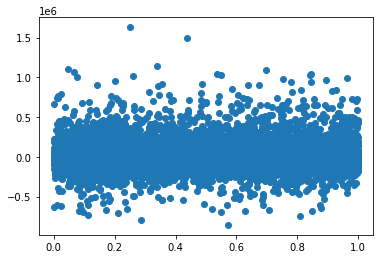

====== outlier eventIndices =======
outlier_eventIndices = [5444, 9478]



In [176]:
# plot residuals
residuals = ols.resid
x_axis = np.linspace(0, 1, len(residuals))
print(f"len(residuals) = {len(residuals)}")
plt.scatter(x_axis, residuals)
plt.show()

ols_eventIndex = df_clean[col_eventIndex]
ols_resid = ols.resid
ols_eventIndex_resid = list(zip(ols_eventIndex, ols_resid))
outlier_eventIndices = []
for eventIndex, resid in ols_eventIndex_resid:
    if np.abs(resid) > 1.25e6:
        outlier_eventIndices.append(eventIndex)
print(f"====== outlier eventIndices =======")
print(f"outlier_eventIndices = {repr(outlier_eventIndices)}\n")

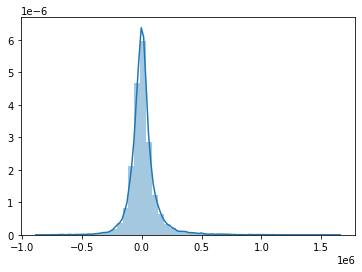

In [177]:
sns.distplot(residuals)
plt.show()

In [178]:
# How can we test that our residuals are normal? 
# H0: data is normal
# HA: data is not normal
scs.shapiro(residuals)

# p = 0.87 -> fail to reject the null, therefore residuals are normally distributed 

ShapiroResult(statistic=0.8398824334144592, pvalue=0.0)